# Multivariate Linear Regression

In this notebook, I'm going to be dealing with Linear Regression on a dataset with multiple features and an output variable, otherwise known as Multivariate Linear Regression. Just so you understand, I'm gonna be refrain from using any scikit-learn or similar imports and go under the hood and attempt to do the computations myself. The goal is to understand better how these algorithms work under the hood, in order to get a better intuition.

In [272]:
# Importing Necessary Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

The above libraries are some bare minimum which I had to import to make this notebook somewhat concise and not ending up covering a lot of stuff which might turn out to be irrelevant for the purpose of this notebook. Also, these libraries are proven to be fast and I would not have to worry too much on things like writing a function for matrix multiplication which might turn out to have a huge time complexity.

In [273]:
# Importing Dataset and Visualizing first few rows
data = pd.read_csv("./data.txt", sep=",", names=["Size", "Bedrooms", "Price"])
data.head(5)

,Size,Bedrooms,Price
0,2104,3,399900
1,1600,3,329900
2,2400,3,369000
3,1416,2,232000
4,3000,4,539900


### About the Dataset
Our dataset consists of housing prices in a particular city as output feature (y), along with two input features, size of the house in square feet and number of bedrooms. This dataset has been obtained from one of the training examples in Andrew Ng's Machine Learning course in Coursera. To view more of the course details [click here](https://github.com/bacon-delight/machine-learning/tree/master/All%20Files), or to visit the course, [click here](https://www.coursera.org/learn/machine-learning). I highly recommend going through his course, it's awesome and will get you deep into how machine learning algorithms work.

Input Features:
- Size of house (in square feet)
- Number of bedrooms

Output Variable:
- Price of house

### Visualizing the Dataset
Before going furthur, I want to take a moment and visualize the imported dataset

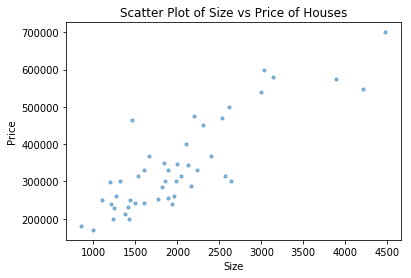

In [274]:
# Plotting Size vs Price
plt.scatter(data['Size'], data['Price'], s=10, alpha=0.5)
plt.title('Scatter Plot of Size vs Price of Houses')
plt.xlabel('Size')
plt.ylabel('Price')
plt.show()

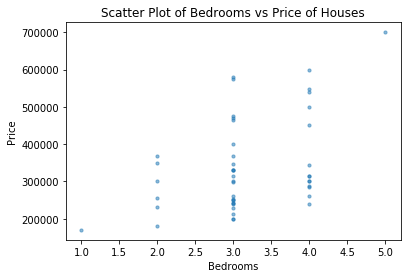

In [275]:
# Plotting Bedrooms vs Price
plt.scatter(data['Bedrooms'], data['Price'], s=10, alpha=0.5)
plt.title('Scatter Plot of Bedrooms vs Price of Houses')
plt.xlabel('Bedrooms')
plt.ylabel('Price')
plt.show()

### Normalizing the Data
In this type of dataset where we have one of the feature ranging between 0 to 700k, and another ranging between 0 and 5000, our cost function can turn out to be highly eliptical ([click here](https://github.com/bacon-delight/machine-learning/blob/master/All%20Files/W02%20-%20C01%20-%20Multivariate%20Linear%20Regression.pdf) for explanation, scroll to "Feature Scaling" in the document). In such a scenario, Gradient Descent may oscillate back and forth and take a ling time to reach the global minimum. We will normalize our data so that the features are on a similar scale and gradient descent can hopefully find a much more direct path to the global optimum.

To scale the input features, we will use **Mean Normalization**.
\begin{align}
x_i = \frac{\text{Actual} \space x_i - \mu_1}{\text{Range of} \space x_i}
\end{align}

Where,
- $i$ = $i^{th}$ Feature
- $x_i$ = Value of $i^{th}$ Feature
- $\mu$ = Mean
- $\mu_i$ = Mean of $i^{th}$ Feature

In [276]:
# Splitting Dataset into input features (X) and output variables (y)
X = np.transpose(np.array([data['Size'], data['Bedrooms']]))
y = np.transpose(np.array([data['Price']]))
print('Shape of X: ', X.shape)
print('Shape of y: ', y.shape)

Shape of X:  (47, 2)
Shape of y:  (47, 1)


In [277]:
# Function for Feature Normalization
def normalizeFeatures(X):
    number_of_rows = np.size(X,0)
    number_of_columns = np.size(X,1)
    X_norm = np.zeros((number_of_rows,number_of_columns), dtype="float")
    sigma = np.zeros(number_of_columns, dtype="float")
    mu = np.zeros(number_of_columns, dtype="float")
    for column in range(number_of_columns):
        sigma[column] = np.std(X[:,column])
        mu[column] = np.mean(X[:,column])
        X_norm[:,column] = (X[:,column]-mu[column])/sigma[column]
    return X_norm, mu, sigma

In [278]:
# Normalizing the Input Features
X, mu, sigma = normalizeFeatures(X)

Now that the input features have been normalized, I want to take into account the intercept term $\theta_0$, and add an extra column of 1's to our input features, $x_0$ (for explanation, [click here](https://github.com/bacon-delight/machine-learning/blob/master/All%20Files/W01%20-%20C02%20-%20Model%20%26%20Cost%20Function.pdf)). This is to simplify the hypothesis, as explained below in the next section.

In [279]:
# Adding an extra column for taking into account the intercept term
m = y.size
X = np.append(np.ones((m, 1), dtype=int), X, axis=1)
print('Shape of X: ', X.shape)

Shape of X:  (47, 3)


### Gradient Descent
In multivariate linear regression, hypothesis sill be:
\begin{align}
h_\theta (x) &= \theta_0 + \theta_1 x_1 + \theta_2 x_2 + \cdots + \theta_n x_n \\
&= \theta_0 x_0 + \theta_1 x_1 + \theta_2 x_2 + \cdots + \theta_n x_n \quad [Let \space x_0 = 1] \\
&= \theta^T x
\end{align}
This is why I added the column of ones as $x_0$ in the input features

Therefore, we get the following two matrices,
\begin{align}
x =
\begin{bmatrix}
x_0 \\
x_1 \\
\vdots \\
x_n
\end{bmatrix} _{[(n+1)*1]}
\quad \quad \quad \quad
\theta =
\begin{bmatrix}
\theta_0 \\
\theta_1 \\
\vdots \\
\theta_n
\end{bmatrix} _{[(n+1)*1]}
\end{align}
Parameters = $\theta_0, \theta_1, \theta_2, \cdots, \theta_n = \theta$

**Cost Function** will turn out to be:
\begin{align}
J(\theta_0, \theta_1, \theta_2, \cdots, \theta_n) &= \frac{1}{2m} \dot \sum^m_{i=1} (h_\theta (x^{(i)}) - y^{(i)})^2
\\
=> J(\theta) &= \frac{1}{2m} \dot \sum^m_{i=1} (h_\theta (x^{(i)}) - y^{(i)})^2
\end{align}

In [280]:
# Function for Computing Cost Function
def costFunction(theta):
    J_sum = 0
    for i in range(m):
        J_sum += ((theta[0] + theta[1] * X[i][1]) - y[i])**2
    J = (1/(2*m)) * J_sum
    return J

**Gradient Descent Algorithm:**

*repeat {*
\begin{align}
\theta_j := \theta_j - \alpha \frac{\partial}{\partial \theta_j} J(\theta_0, \theta_1, \theta_2, \cdots, \theta_n)
\end{align}
*} (Simultaneously update $\theta_j$ for every $j=0, 1, 2, \cdots, n$)*

Plugging in the value of $J(\theta_0, \theta_1, \theta_2, \cdots, \theta_n)$:

*repeat {*
\begin{align}
\theta_j := \theta_j - \alpha \frac{1}{m} \sum^m_{i=1} (h_\theta(x^{(i)}) - y^{(i)}) x^{(i)}_j
\end{align}
*} (Simultaneously update $\theta_j$ for every $j=0, 1, 2, \cdots, n$)*

In [281]:
# Function for Running Gradient Descent
def gradientDescent(theta, iterations, alpha):
    J_history = np.zeros(iterations, dtype=float)
    for i in range(iterations):
        error = np.dot(X,theta)-y
        theta = theta-((alpha/m)*np.dot(np.transpose(X),error))
        J_history[i] = costFunction(theta)
    return J_history, theta

In [282]:
# Initializing Theta
theta = np.zeros((np.size(X,1),1), dtype=float)
print('Shape of Theta: ', theta.shape)

Shape of Theta:  (3, 1)


In [283]:
# Setting Number of Iterations and Learning Rate
iterations=1000
alpha=0.01

In [284]:
# Let's run the Gradient Descent now
J_history, theta = gradientDescent(theta, iterations, alpha)

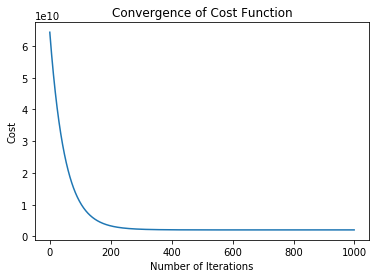

In [285]:
# Plotting the convergence
plt.plot(np.arange(iterations), J_history)
plt.title('Convergence of Cost Function')
plt.xlabel('Number of Iterations')
plt.ylabel('Cost')
plt.show()

In [290]:
# Let's have a look at the theta value computed from the gradient descent
print('Computed Values of Theta from Gradient Descent:')
for i in range(np.size(X,1)):
    print('Theta ', (i), ' : ', float(theta[i]))

Computed Values of Theta from Gradient Descent:
Theta  0  :  340397.96353531966
Theta  1  :  108742.6562723772
Theta  2  :  -5873.229933827041


### Predicting Prices
Now that we have minimized the cost function and got the $\theta$ values to fit into the hypothesis, we should move on and try predicting the prices for a new set of input features.

\begin{align}
X =
\begin{bmatrix}
x_1 \\
x_2 \\
\vdots \\
x_n
\end{bmatrix}
\quad \quad \quad \quad
\text{We will add for the intercept $x_0=1$ later}
\end{align}

We also have,

\begin{align}
\mu =
\begin{bmatrix}
\mu_1 \\
\mu_2 \\
\vdots \\
\mu_n
\end{bmatrix}
\quad \quad \quad \quad
\sigma
\begin{bmatrix}
\sigma_1 \\
\sigma_2 \\
\vdots \\
\sigma_n
\end{bmatrix}
\end{align}

First, we will do the following:
\begin{align}
X = \frac{X - \mu}{\sigma}
\end{align}

Now that we have our features normalized, we can go ahead and add $x_0=1$ to account for the intercept term

\begin{align}
X =
\begin{bmatrix}
x_0 \\
x_1 \\
x_2 \\
\vdots \\
x_n
\end{bmatrix}
\quad \quad \quad \quad
\theta =
\begin{bmatrix}
\theta_0 \\
\theta_1 \\
\theta_2 \\
\vdots \\
\theta_n
\end{bmatrix}
\end{align}

Here, append $x_0=1$ to the existing matrix of input features

So finally, to get our output,
\begin{align}
y = X^T \theta
\end{align}

In [395]:
# Let's predict the prices for certain set of input features
new_features = np.array([[1650, 3], [3970, 5], [750, 1], [4720, 6], [2640, 2]], dtype=float)
new_features_norm = np.append(np.ones((np.size(new_features, 0), 1), dtype=int), (new_features.reshape(np.size(new_features, 0),np.size(new_features, 1))-mu)/sigma, axis=1)
predicted_value = np.dot(new_features_norm,theta)

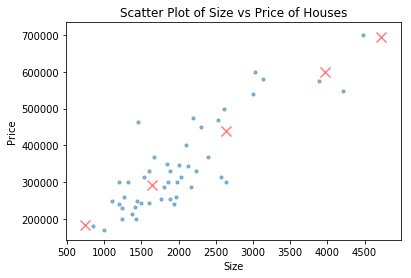

In [396]:
# Plotting Size vs Price
plt.scatter(data['Size'], data['Price'], s=10, alpha=0.5)
plt.scatter(new_features[:, 0], predicted_value, s=100, alpha=0.5, color='r', marker='x')
plt.title('Scatter Plot of Size vs Price of Houses')
plt.xlabel('Size')
plt.ylabel('Price')
plt.show()

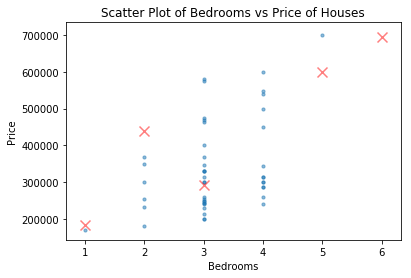

In [397]:
# Plotting Bedrooms vs Price
plt.scatter(data['Bedrooms'], data['Price'], s=10, alpha=0.5)
plt.scatter(new_features[:, 1], predicted_value, s=100, alpha=0.5, color='r', marker='x')
plt.title('Scatter Plot of Bedrooms vs Price of Houses')
plt.xlabel('Bedrooms')
plt.ylabel('Price')
plt.show()